## Results of Host Prediction
### Dataset: EMBL mapping, Vertebrates, Non-IDV

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 5

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
! pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import seaborn

In [3]:
seaborn.__version__

'0.13.0'

In [4]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../..']

In [5]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils

In [6]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"

def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath):
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    sns.set_context("paper")
    FIGURE_CONFIG = {
        "figsize": (16, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", 
                     order=metadata_sorted, linewidth=1.5, fliersize=5,
                     palette="colorblind")
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=20)
    visualization_utils.wrap_ticklabels(ax, axis="x")
    visualization_utils.view(figure_output_filepath)
    print(figure_output_filepath)
    plt.show()
    return auprc_results_df, metadata_sorted

In [7]:
output_filepaths = {
    "LR": os.path.join(os.getcwd(), "..","..", "..", "..","output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240723/host_multi/kmer_k3_virus_host_name_multi__lr_output.csv"),
    "RF": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240723/host_multi/kmer_k3_virus_host_name_multi__rf_output.csv"),
    "SVM": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240723/host_multi/kmer_k3_virus_host_name_multi__svm_output.csv"),
    #"FNN": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_fnn-l_10-d_1024-lr1e-3_output.csv"),
    "CNN": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_cnn-l_4-d_1024-k3s1-lr1e-3_output.csv"),
    "RNN": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_rnn-l_6-d_1024-lr1e-5_output.csv"),
    "LSTM": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240722/host_multi/nlp_no_msl_lstm-l_2-d_1024-lr1e-3_output_mod.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20241127/host_multi/external/uniref90viridae_prostt5_msl2048_bn_fnn_2l_d1024_lr3e-4_output.csv"),
    #"ESM2": os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20241124/host_multi/external/uniref90viridae_esm2_msl2048_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Transformer-Encoder": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240717/host_multi/nlp_no_msl_transformer-l_6-h_8-d_1024-msl2048-lr1e-4_output.csv"),
    #"ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240827/proteinbert_prediction_results_20240827_231839.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5_seq_len_in_99.9percentile/20240826/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_hybrid_attention_msl256s64ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
    
}
classes = ["Human", "Capybara", "Himalayan marmot", "Pig", "Red junglefowl"]

Read output LR = (31690, 7)
Read output RF = (31690, 7)
Read output SVM = (31690, 7)
Read output CNN = (15845, 7)
Read output RNN = (15845, 7)
Read output LSTM = (15845, 7)
Read output ProstT5 = (15845, 7)
Read output VirProBERT = (15845, 7)


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../src/utils/visualization_utils.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0)


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../output/visualization/temp_new/host_multi_all_models_classwise_aurpc_boxplot.pdf


<Figure size 432x288 with 0 Axes>

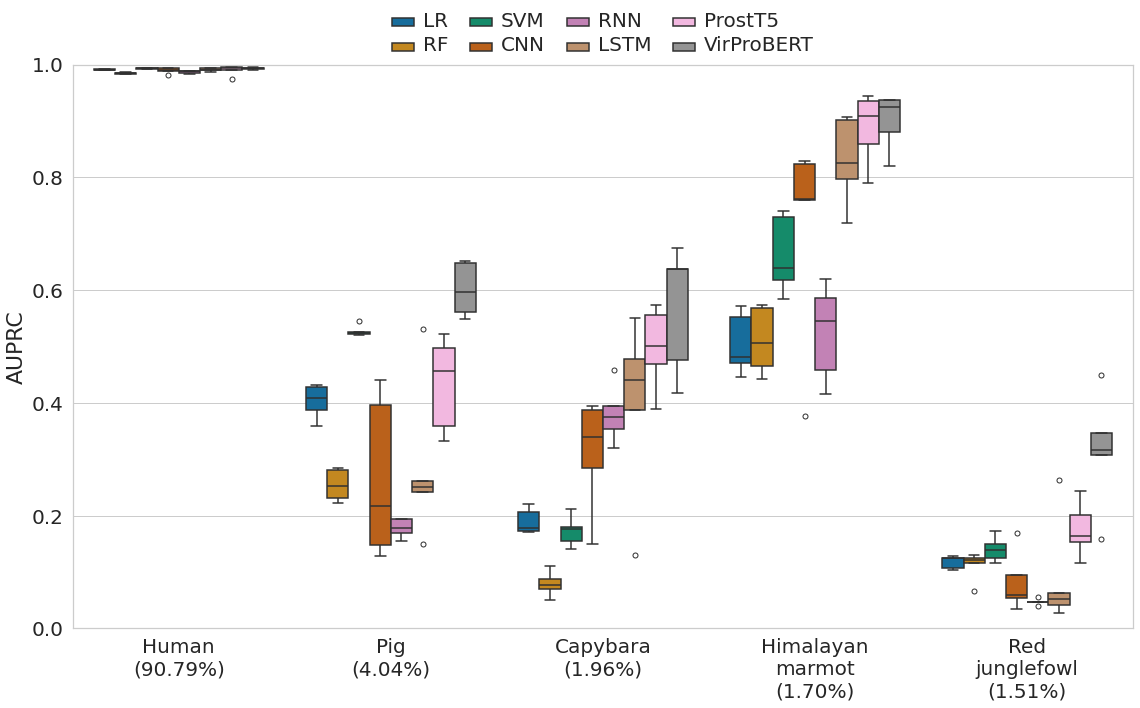

In [8]:
figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "output/visualization/temp_new/host_multi_all_models_classwise_aurpc_boxplot.pdf")
Path(os.path.dirname(figure_output_filepath)).mkdir(parents=True, exist_ok=True)
auprc_results_df, metadata_sorted = class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath)

/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../src/utils/visualization_utils.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0)


<Figure size 432x288 with 0 Axes>

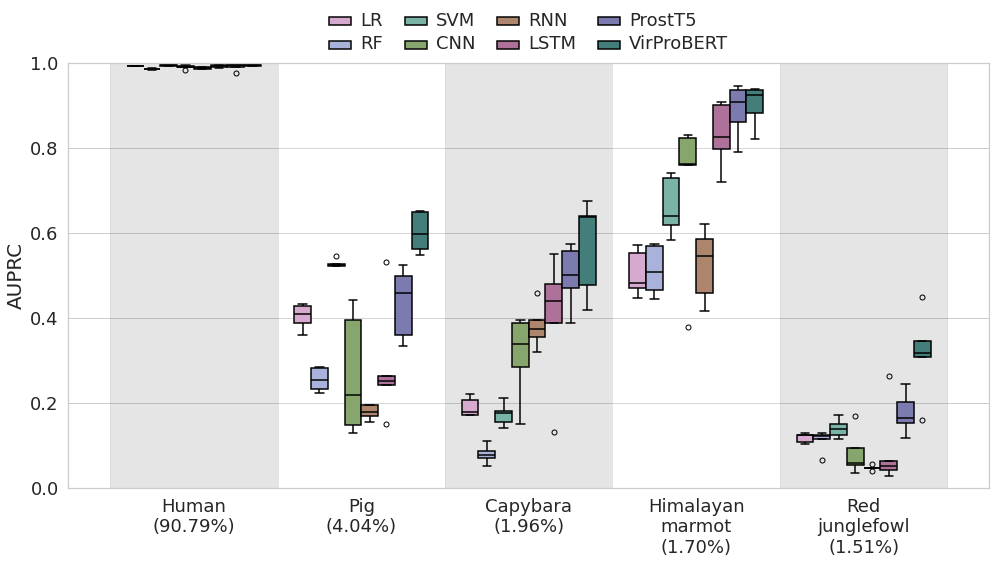

In [9]:
sns.set_context("paper")
sns.axes_style("whitegrid")
FIGURE_CONFIG = {
    "figsize": (14, 8),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}

color_palette = sns.cubehelix_palette(start=3, rot=4.5, hue=1, gamma=0.9, dark=0.7, light=0.4, reverse=True, n_colors=auprc_results_df["model"].nunique())

visualization_utils.pre_plot_config(FIGURE_CONFIG)
ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", 
                 order=metadata_sorted, linewidth=1.5, fliersize=5, linecolor="black",
                 palette=color_palette)

bg_colors = [ "gray", "white",]

plt.draw()

ax.set_ylim(0, 1)
ax.set_ylabel("AUPRC", size=20)
ax.set_xlabel("", size=20, labelpad=2)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
plt.setp(ax.get_legend().get_texts(), fontsize=18)
visualization_utils.wrap_ticklabels(ax, axis="x")

n_classes = auprc_results_df["class"].nunique()
for i in range(n_classes):
    ax.axvspan(i - .5, i + .5, color=bg_colors[i%2], alpha=0.2)

visualization_utils.view(figure_output_filepath)
plt.show()

In [10]:
auprc_results_df[["model", "class", "auprc"]].groupby(["model", "class"]).mean("auprc")

auprc
model      class                             
CNN        Capybara (1.96%)          0.310939
           Himalayan marmot (1.70%)  0.710000
           Human (90.79%)            0.989391
           Pig (4.04%)               0.265663
           Red junglefowl (1.51%)    0.082012
LR         Capybara (1.96%)          0.189589
           Himalayan marmot (1.70%)  0.503898
           Human (90.79%)            0.991283
           Pig (4.04%)               0.402781
           Red junglefowl (1.51%)    0.117548
LSTM       Capybara (1.96%)          0.396868
           Himalayan marmot (1.70%)  0.830207
           Human (90.79%)            0.990792
           Pig (4.04%)               0.287136
           Red junglefowl (1.51%)    0.089193
ProstT5    Capybara (1.96%)          0.497645
           Himalayan marmot (1.70%)  0.887284
           Human (90.79%)            0.989907
           Pig (4.04%)               0.433608
           Red junglefowl (1.51%)    0.175295
RF         Capybara (1.96%)          0.078824
           Himalayan marmot (1.70%)  0.511055
           Human (90.79%)            0.984707
           Pig (4.04%)               0.254578
           Red junglefowl (1.51%)    0.111262
RNN        Capybara (1.96%)          0.380006
           Himalayan marmot (1.70%)  0.524389
           Human (90.79%)            0.986832
           Pig (4.04%)               0.178179
           Red junglefowl (1.51%)    0.047204
SVM        Capybara (1.96%)          0.172497
           Himalayan marmot (1.70%)  0.662138
           Human (90.79%)            0.992765
           Pig (4.04%)               0.527303
           Red junglefowl (1.51%)    0.139928
VirProBERT Capybara (1.96%)          0.568408
           Himalayan marmot (1.70%)  0.899886
           Human (90.79%)            0.993320
           Pig (4.04%)               0.601161
           Red junglefowl (1.51%)    0.315789